In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import xlrd
import os
from pandas import DataFrame as DF
from pandas import read_csv, read_excel, merge, concat
import datetime as dt
from datetime import timedelta

In [2]:
def string_to_float(x):
    if isinstance(x, str):
        try:
            y = float(x)
        except Exception as e:
            y = np.nan
    else:
        y = float(x)
    return y

def compute_bal(amt, pmt_series):
    try:
        amt = float(amt)
    except Exception as e:
        print(e)
    bal_series = []
    for i, pmt in enumerate(pmt_series):
        if i == 0:
            bal = amt - pmt
        else:
            bal = bal_series[i - 1] - pmt
        bal_series.append(bal)
    return bal_series



def detect_type(data, obj='loan'):
    if obj.lower() == 'loan':
        col = data.loan_plus_intr_ld.values
    elif obj.lower() == 'pmt':
        col = data.payment_amt_ld.values
    if all([str(val) == 'nan' for val in col]):
        obj_type = 0
    else:
        obj_type = 1
    return obj_type
    
def get_usd_ld_loan_balance(input_data, x_rate):
    data = input_data.sort_values(by=['loan_id', 'payment_dt'])
    data.index = range(data.shape[0])
    data['loan_bal_usd'] = [np.nan] * len(data)
    data['loan_bal_ld'] = [np.nan] * len(data)
    for ln_id in np.unique(data.loan_id):
#         print(ln_id)
        data = DF(data)
        subdf = DF(data.loc[data.loan_id==ln_id])
        subdf = subdf.sort_values(by=['loan_id', 'payment_dt']) # sort by increasing date
        indx = subdf.index
#         print(indx)
        # get loan amount
        ld_ln_amt = subdf.loan_plus_intr_ld.values[0]
        usd_ln_amt = subdf.loan_plus_intr_usd.values[0]
#         print(usd_ln_amt)

        ln_type = detect_type(subdf, 'loan')
        pmt_type = detect_type(subdf, 'pmt')
        if (ln_type == 0 or ln_type ==1) and (pmt_type == 0 or pmt_type == 1):
            pmt_ld = subdf.payment_amt_ld.values
            pmt_usd = subdf.payment_amt_usd.values

            if ln_type == 0 and pmt_type == 0:
                data.loc[indx[0]:indx[-1], -2:-1] = compute_bal(usd_ln_amt, pmt_usd) # compute usd loan balance
            elif ln_type == 0 and pmt_type == 1: #mismatch between loan and payment currencies
                conv_pmt = np.array([float(val) for val in pmt_ld]) / x_rate # convert payment to loan currency
                data.loc[indx[0]:indx[-1], -2:-1] = compute_bal(usd_ln_amt, conv_pmt) # compute loan balance
            elif ln_type == 1 and pmt_type == 0: # mismatch between loan and payment currencies
                conv_pmt = x_rate * np.array([float(val) for val in pmt_usd]) 
                data.loc[indx[0]:indx[-1], -1:] = compute_bal(ld_ln_amt, conv_pmt)
            elif ln_type == 1 and pmt_type == 1:
                data.loc[indx[0]:indx[-1], -1:] = compute_bal(ld_ln_amt, pmt_ld) # compute ld loan balance
        else:
            print('Loan type or payment type not detected!')
    return data


def plot_bars(x_vals, y_vals, fig_size=(5, 4), x_label=None, y_label=None, title=None, pct=None,
             rotation=0, pf=None):
    ld_norm = 1e6
    usd_norm = 1e3
    if pct:
        x_vals = x_vals[:-1]
        total = y_vals[-1]
        y_vals = y_vals[:-1]
        y_vals = 100 * (y_vals / total)
        y_label = 'PCT OF PORTFOLIO'
    if pf and pf.lower() == 'ld':
        if title is None:
            title = 'DISBURSED LD PORTFOLIO'
        if pct is None:
            y_vals = y_vals / ld_norm
            y_label = 'LD ( MM )'
    elif pf and pf.lower() == 'usd':
        if title is None:
            title = 'DISBURSED USD PORTFOLIO'
        if pct is None:
            y_vals = y_vals / usd_norm
            y_label = 'USD ( KK )'
    elif pf and pf.lower() == 'total':
        if title is None:
            title = 'DISBURSED Total PORTFOLIO (USD)'
        if pct is None:
            y_vals = y_vals / usd_norm
            y_label = 'USD ( KK )'
    x_pos = np.arange(1, len(x_vals) + 1)
    plt.figure(figsize=fig_size)
    plt.bar(left=x_pos, height=y_vals, color='lightblue', width=0.8)
    locs, labels = plt.xticks(x_pos, x_vals)
    plt.setp(labels, rotation=rotation) 
    pct_vals = 100 * (y_vals[:2] / y_vals[-1])
    for xyz in zip(x_pos[:2], y_vals[:2], pct_vals): 
        plt.annotate('%.2f%s' % (xyz[-1], '%'), xy=[xyz[0] -0.2, xyz[1]], textcoords='data', fontsize='large')
    
    if pct:
        plt.yticks(np.arange(0, 100, 10))
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if title:
        plt.title(title)
    plt.tight_layout()

In [3]:
ls data/

collections.xlsx  loans.xlsx        payments.xlsx


In [4]:
ipath = 'data/'
opath = 'output/'

tody = str(dt.datetime.today().date())

ofoldr = opath + tody + '/'

'2018-01-06'

In [5]:
if os.path.exists(ofoldr):
    print('exists')
else:
    print('does not exist, and making folder')
    os.mkdir(ofoldr)

exists


### compute  loan disbursed 

In [6]:
ifile = ipath + 'loans.xlsx'

lns = read_excel(ifile)

In [7]:
qa_cols = ['loan_amt_usd', 'loan_amt_ld', 'rate', 'interest_ld', 'interest_usd', 'duration_month', 
          'loan_plus_intr_ld', 'loan_plus_intr_usd']

for col in qa_cols:
    lns[col] = lns[col].apply(string_to_float)

In [8]:
# get approved loans

appr = lns.loc[lns.status == 'approved']
appr.index = range(appr.shape[0])

# get Liberian dollar loans

ld_loan = DF( appr.loc[~appr.loan_amt_ld.isnull()] )
ld_loan.index = range(ld_loan.shape[0])
# get US dollar loans

usd_loan = DF( appr.loc[~appr.loan_amt_usd.isnull()] )
usd_loan.index = range(usd_loan.shape[0])

In [9]:
# get stats by loan_type

ld_ln_grp = ld_loan.groupby("loan_type", as_index=False).agg({"loan_id": "count", 
                                                              "loan_amt_ld": sum})
ld_ln_grp = ld_ln_grp.rename(columns = {"loan_id": "nbr_ld_loans"})

usd_ln_grp = usd_loan.groupby("loan_type", as_index=False).agg({"loan_id": "count", 
                                                               "loan_amt_usd": sum})
usd_ln_grp = usd_ln_grp.rename(columns = {"loan_id": "nbr_usd_loans"})

# merge groups

ln_grps = merge(ld_ln_grp, usd_ln_grp, on="loan_type", how="outer")

# add total row

row = ln_grps.values.sum(axis=0)
row[0] = "total"

ln_grps.loc[-1] = row
ln_grps.index = range(ln_grps.shape[0])

In [10]:
x_rate = 115.0

ln_grps['total_usd_plus_ld'] = ln_grps.loan_amt_ld / x_rate + ln_grps.loan_amt_usd

In [11]:
# save the disbursed loans
ofile = ofoldr + 'disbursed_by_loan_type.csv'
ln_grps.to_csv(ofile, header=True, index=None)

In [12]:
# compute expected collections

exp_ld_coll = appr.loan_plus_intr_ld.sum()

exp_usd_coll = appr.loan_plus_intr_usd.sum()

exp_ttl_coll = exp_ld_coll / x_rate + exp_usd_coll

### get the collections data

In [13]:
ifile = ipath + 'collections.xlsx'
cltn = read_excel(ifile)

cols = ['id', 'loan_id', 'loan_plus_intr_usd', 'loan_plus_intr_ld',
       'payment_dt', 'payment_amt_usd', 'payment_amt_ld']

cltn = DF( cltn[cols] )

qa_cols = ['loan_plus_intr_usd', 'loan_plus_intr_ld', 'payment_amt_usd', 'payment_amt_ld']

for col in qa_cols:
    cltn[col] = cltn[col].apply(string_to_float)

In [14]:
#  compute collections

ld_coll = cltn.payment_amt_ld.sum()

usd_coll = cltn.payment_amt_usd.sum()

ttl_coll = ld_coll / x_rate + usd_coll

pmt = get_usd_ld_loan_balance(cltn, x_rate=115.0)

In [15]:
# save the latest payment table
ofile = ofoldr + 'payment_' + tody + '.xlsx'
pmt.to_excel(ofile, header=True, index=False)

In [16]:
ttl_uncoll = exp_ttl_coll - ttl_coll

ttl_uncoll

5279.7391304347821

### get aggregrates

In [17]:
ttl_disb = ln_grps.total_usd_plus_ld.values[-1:][0]

In [18]:
agg = DF([{'disbursed': ttl_disb, 'collected': ttl_coll, 
                  'uncollected': ttl_uncoll, 'disb_plus_intr': exp_ttl_coll}])

total_cap = 5000.0
expenses = 225.0
bal_cap = total_cap - ttl_disb + ttl_coll - expenses

agg['expenses'] = expenses
agg['beginning_cap'] = total_cap
agg['cash_on_hand'] = bal_cap

In [19]:
# save the aggregates
ofile = ofoldr + 'current_status.xlsx'
agg.to_excel(ofile, header=True, index=False)

### plot summary

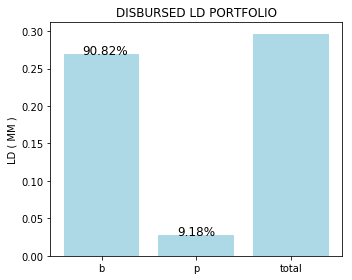

In [20]:
ld_y_vals = ln_grps.loan_amt_ld.values
ld_x_vals = ln_grps.loan_type.values
plot_bars(x_vals=ld_x_vals, y_vals=ld_y_vals, pf='LD', pct=None)
ofile = ofoldr + 'ttl_ld_pf_amt.png'
plt.savefig(ofile, dpi=300, bbox_inches='tight')
plt.show()

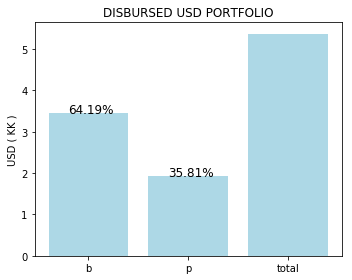

In [21]:
usd_y_vals = ln_grps.loan_amt_usd.values
usd_x_vals = ln_grps.loan_type.values
plot_bars(x_vals=usd_x_vals, y_vals=usd_y_vals, pf='USD', pct=None)
ofile = ofoldr + 'ttl_usd_pf_amt.png'
plt.savefig(ofile, dpi=300, bbox_inches='tight')
plt.show()

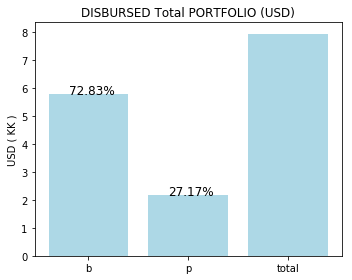

In [22]:
ttl_y_vals = ln_grps.total_usd_plus_ld.values
ttl_x_vals = ln_grps.loan_type.values
plot_bars(x_vals=ttl_x_vals, y_vals=ttl_y_vals, pf='total', pct=None)
ofile = ofoldr + 'ttl_pf_amt.png'
plt.savefig(ofile, dpi=300, bbox_inches='tight')
plt.show()

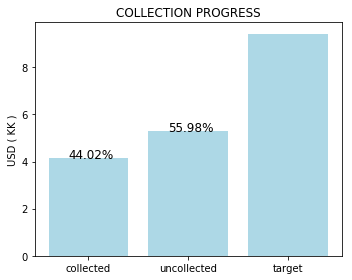

In [23]:
xvals = np.array(['collected', 'uncollected', 'target'])
yvals = np.array([agg.collected.values[0], agg.uncollected.values[0], 
                  agg.disb_plus_intr.values[0]])
plot_bars(x_vals=xvals, y_vals=yvals, pf='usd', pct=None, title='COLLECTION PROGRESS')
ofile = ofoldr + 'collection_summary.png'
plt.savefig(ofile, dpi=300, bbox_inches='tight')
plt.show()

### load previous payment (the original v0 )

In [24]:
# ifile = ipath + 'payments.xlsx'
# old_pmt = read_excel(ifile)

# cols = ['id', 'loan_id', 'loan_plus_intr_usd', 'loan_plus_intr_ld',
#        'payment_dt', 'payment_amt_usd', 'payment_amt_ld', 'loan_bal_usd',
#        'loan_bal_ld']

# old_pmt = DF( old_pmt[cols])